# Making BOIDS algorithm
Pseudocode:

```
# For every boid . . .
for each boid (boid):

    # Zero all accumulator variables
    xpos_avg, ypos_avg, xvel_avg, yvel_avg, neighboring_boids, close_dx, close_dy = 0

    # For every other boid in the flock . . .
    for each other boid (otherboid):

        # Compute differences in x and y coordinates
        dx = boid.x - otherboid.x
        dy = boid.y - otherboid.y

        # Are both those differences less than the visual range?
        if (abs(dx)<visual_range and abs(dy)<visual_range):  

            # If so, calculate the squared distance
            squared_distance = dx*dx + dy*dy

            # Is squared distance less than the protected range?
            if (squared_distance < protected_range_squared):

                # If so, calculate difference in x/y-coordinates to nearfield boid
                close_dx += boid.x - otherboid.x 
                close_dy += boid.y - otherboid.y

            # If not in protected range, is the boid in the visual range?
            else if (squared_distance < visual_range_squared):

                # Add other boid's x/y-coord and x/y vel to accumulator variables
                xpos_avg += otherboid.x 
                ypos_avg += otherboid.y 
                xvel_avg += otherboid.vx
                yvel_avg += otherboid.vy

                # Increment number of boids within visual range
                neighboring_boids += 1 

    # If there were any boids in the visual range . . .            
    if (neighboring_boids > 0): 

        # Divide accumulator variables by number of boids in visual range
        xpos_avg = xpos_avg/neighboring_boids 
        ypos_avg = ypos_avg/neighboring_boids
        xvel_avg = xvel_avg/neighboring_boids
        yvel_avg = yvel_avg/neighboring_boids

        # Add the centering/matching contributions to velocity
        boid.vx = (boid.vx + 
                   (xpos_avg - boid.x)*centering_factor + 
                   (xvel_avg - boid.vx)*matching_factor)

        boid.vy = (boid.vy + 
                   (ypos_avg - boid.y)*centering_factor + 
                   (yvel_avg - boid.vy)*matching_factor)

    # Add the avoidance contribution to velocity
    boid.vx = boid.vx + (close_dx*avoidfactor)
    boid.vy = boid.vy + (close_dy*avoidfactor)

    # If the boid is near an edge, make it turn by turnfactor
    if outside top margin:
        boid.vy = boid.vy + turnfactor
    if outside right margin:
        boid.vx = boid.vx - turnfactor
    if outside left margin:
        boid.vx = boid.vx + turnfactor
    if outside bottom margin:
        boid.vy = boid.vy - turnfactor

    # Calculate the boid's speed
    # Slow step! Lookup the "alpha max plus beta min" algorithm
    speed = sqrt(boid.vx*boid.vx + boid.vy*boid.vy)

    # Enforce min and max speeds
    if speed < minspeed:
        boid.vx = (boid.vx/speed)*minspeed
        boid.vy = (boid.vy/speed)*maxspeed
    if speed > maxspeed:
        boid.vx = (boid.vx/speed)*maxspeed
        boid.vy = (boid.vy/speed)*maxspeed

    # Update boid's position
    boid.x = boid.x + boid.vx
    boid.y = boid.y + boid.vy
```

In [1]:
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
boid_count = 10

In [4]:
limits = np.array([2000, 2000])

In [5]:
positions = np.random.rand(2, boid_count) * limits[:, np.newaxis]
positions

array([[1919.3985955 ,  408.77043117,  994.34537168, 1568.92953223,
        1871.96296511,  638.25012026, 1492.22145752,   90.70003883,
         215.05558109,  230.43614635],
       [  91.96204342,  343.99307074,  177.56384636,  437.38182459,
        1547.83883566, 1469.88557351,  276.95103044, 1778.47088458,
        1747.45055698,  616.55291353]])

In [6]:
def new_flock(count, lower_limits, upper_limits):
    width = upper_limits - lower_limits
    return (lower_limits[:, np.newaxis] + np.random.rand(2, count) * width[:, np.newaxis])

In [7]:
positions = new_flock(boid_count, np.array([100, 900]), np.array([200, 1100]))

In [8]:
velocities = new_flock(boid_count, np.array([0, -20]), np.array([10, 20]))
velocities

array([[  4.87079865,   6.68883997,   2.63884782,   0.14264448,
          3.46571111,   4.56274976,   6.16087937,   5.95050226,
          8.14933918,   5.01651851],
       [  6.46845265,  13.36262849, -13.87144351, -16.77525223,
        -14.98658593, -13.56410054,  -9.24241253,   6.38201675,
          8.81822247,  11.70253397]])

In [9]:
positions += velocities

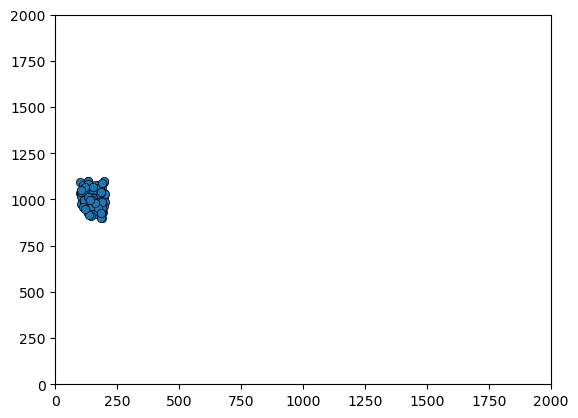

In [10]:
# create a simple plot
# initial x position in [100, 200], initial y position in [900, 1100]
# initial x velocity in [0, 10], initial y velocity in [-20, 20]
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))

figure = plt.figure()
axes = plt.axes(xlim=(0, limits[0]), ylim=(0, limits[1]))
scatter = axes.scatter(positions[0, :], positions[1, :],
                       marker='o', edgecolor='k', lw=0.5)

In [26]:
def update_boids(positions, velocities):
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    square_distances = np.sum(squared_displacements, 0)
    alert_distance = 100
    far_away = square_distances > alert_distance
    separations_if_close = np.copy(separations)
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    velocities += np.sum(separations_if_close, 1)

    velocity_differences = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    formation_flying_distance = 10000
    formation_flying_strength = 0.125
    very_far = square_distances > formation_flying_distance
    velocity_differences_if_close = np.copy(velocity_differences)
    velocity_differences_if_close[0, :, :][very_far] = 0
    velocity_differences_if_close[1, :, :][very_far] = 0
    velocities -= np.mean(velocity_differences_if_close, 1) * formation_flying_strength

    positions += velocities

In [27]:
def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())


anim = animation.FuncAnimation(figure, animate,
                               frames=200, interval=50)


positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))

In [28]:
from IPython.display import HTML
HTML(anim.to_jshtml())